In [39]:
import numpy as np 
import random

def compute_distance(point1, point2):
    delta_x = point2[0] - point1[0]
    delta_y = point2[1] - point1[1]
    return np.sqrt((delta_x ** 2) + (delta_y ** 2))

def compute_distance_path(cities, start, path):
    distance = 0
    distance += compute_distance(cities[start], cities[path[0]])
    for stop in range(len(path) - 1):
        distance += compute_distance(cities[path[stop]], cities[path[stop + 1]])
    distance += compute_distance(cities[path[len(path) - 1]], cities[start])
    return distance

def compute_first_path(start, cities):
    cities_list = list(range(len(cities)))  # [0, 1, 2, ..., r]
    random_path = [city for city in cities_list if city != start]  # Exclude the start city
    random.shuffle(random_path)  # Shuffle the path
    return random_path

def find_neighbor(path):
    new_path = path.copy()
    index1, index2 = random.sample(range(len(path)), 2)  # Pick two unique indices
    new_path[index1], new_path[index2] = new_path[index2], new_path[index1]  # Swap two random cities
    return new_path

def find_close_neighbor(cities, path, k):
    new_path = path.copy()
    index1, index2 = random.sample(range(len(path)), 2)  # Pick two unique indices
    current_distance = compute_distance(cities[path[index1]], cities[path[index2]])
    while current_distance >= k:
        index1, index2 = random.sample(range(len(path)), 2)
        current_distance = compute_distance(cities[path[index1]], cities[path[index2]])
    new_path[index1], new_path[index2] = new_path[index2], new_path[index1]  # Swap two random cities
    return new_path

def simulated_annealing(start, cities, max_iterations=500_000):
    current_path = compute_first_path(start, cities)
    current_distance = compute_distance_path(cities, start, current_path)
    best_path = current_path[:]
    best_distance = current_distance
    best_distances = [current_distance]
    current_distances = [current_distance]
    neighbors = []

    for n in range(1, max_iterations + 1):
        neighbor = find_neighbor(current_path)
        distance_neighbor = compute_distance_path(cities, start, neighbor)
        neighbors.append(distance_neighbor)
        if distance_neighbor < current_distance:  
            current_path = neighbor
            current_distance = distance_neighbor
        else:  
            delta = current_distance - distance_neighbor
            temperature = np.log(1 + n) 
            acceptance_probability = np.exp(delta / temperature)
            
            if random.random() < acceptance_probability:
                current_path = neighbor
                current_distance = distance_neighbor
        
        if current_distance < best_distance:
            best_path = current_path[:]
            best_distance = current_distance
        
        best_distances.append(best_distance)
        current_distances.append(current_distance)
        
    return best_path, best_distance, best_distances, current_distances, neighbors

def simulated_annealing2(start, cities, k, max_iterations=500_000):
    current_path = compute_first_path(start, cities)
    current_distance = compute_distance_path(cities, start, current_path)
    best_path = current_path[:]
    best_distance = current_distance
    best_distances = [current_distance]
    current_distances = [current_distance]
    neighbors = []
    for n in range(1, max_iterations + 1):
        neighbor = find_close_neighbor(cities, current_path, k)
        distance_neighbor = compute_distance_path(cities, start, neighbor)
        neighbors.append(distance_neighbor)
        if distance_neighbor < current_distance:  # Accept better neighbor
            current_path = neighbor
            current_distance = distance_neighbor
        else:  # Accept worse neighbor probabilistically
            delta = current_distance - distance_neighbor
            temperature = np.log(1 + n)  # Calculate temperature
            acceptance_probability = np.exp(delta / temperature)
            
            if random.random() < acceptance_probability:
                current_path = neighbor
                current_distance = distance_neighbor

        if current_distance < best_distance:
            best_path = current_path[:]
            best_distance = current_distance
        
        best_distances.append(best_distance)
        current_distances.append(current_distance)
        
    return best_path, best_distance, best_distances, current_distances, neighbors

In [41]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def solve_tsp(distance_matrix):

    n = len(distance_matrix) 
    model = gp.Model("TSP")
    x = model.addVars(n, n, vtype=GRB.BINARY, name="x")
    model.setObjective(gp.quicksum(distance_matrix[i][j] * x[i, j] for i in range(n) for j in range(n)), GRB.MINIMIZE)
    model.addConstrs(gp.quicksum(x[i, j] for j in range(n) if i != j) == 1 for i in range(n))
    model.addConstrs(gp.quicksum(x[i, j] for i in range(n) if i != j) == 1 for j in range(n))
    u = model.addVars(n, vtype=GRB.CONTINUOUS, name="u")
    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                model.addConstr(u[i] - u[j] + n * x[i, j] <= n - 1)
    model.optimize()
    if model.status == GRB.OPTIMAL:
        route = extract_tour(x, n)
        optimal_cost = model.objVal
        return route, optimal_cost
    else:
        raise Exception("No optimal solution found.")

def extract_tour(x, n):
    tour = []
    current_city = 0
    visited = set()
    while len(visited) < n:
        visited.add(current_city)
        tour.append(current_city)
        for j in range(n):
            if j != current_city and x[current_city, j].X > 0.5:
                current_city = j
                break
    return tour

def compute_distance(point1, point2):
    delta_x = point2[0] - point1[0]
    delta_y = point2[1] - point1[1]
    return np.sqrt((delta_x ** 2) + (delta_y ** 2))

def compute_distance_matrix(cities):
    n = len(cities)
    distance_matrix = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = compute_distance(cities[i], cities[j])
    return distance_matrix

In [43]:
x_range = (-100, 100)  # x-coordinate range
y_range = (-100, 100)  # y-coordinate range
start = 0
difference = []

for cities_count in range(3, 30):
    cities = [(np.random.randint(x_range[0], x_range[1]), np.random.randint(y_range[0], y_range[1])) for _ in range(cities_count)]
    final_path1, final_distance1, best_distances1, current_distances1, neighbors = simulated_annealing(start, cities)
    distance_matrix = compute_distance_matrix(cities)
    route, optimal_cost = solve_tsp(distance_matrix)
    difference.append((final_distance1 - optimal_cost)/optimal_cost)
    print(f"Cities Count: {cities_count}")

print(difference)

    

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 12 columns and 18 nonzeros
Model fingerprint: 0x670e46b4
Variable types: 3 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 8 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 214.823 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.148232564821e+02, best bound 2.148232564821e+02, gap 0.0000%
Cities Count: 3
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using u

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


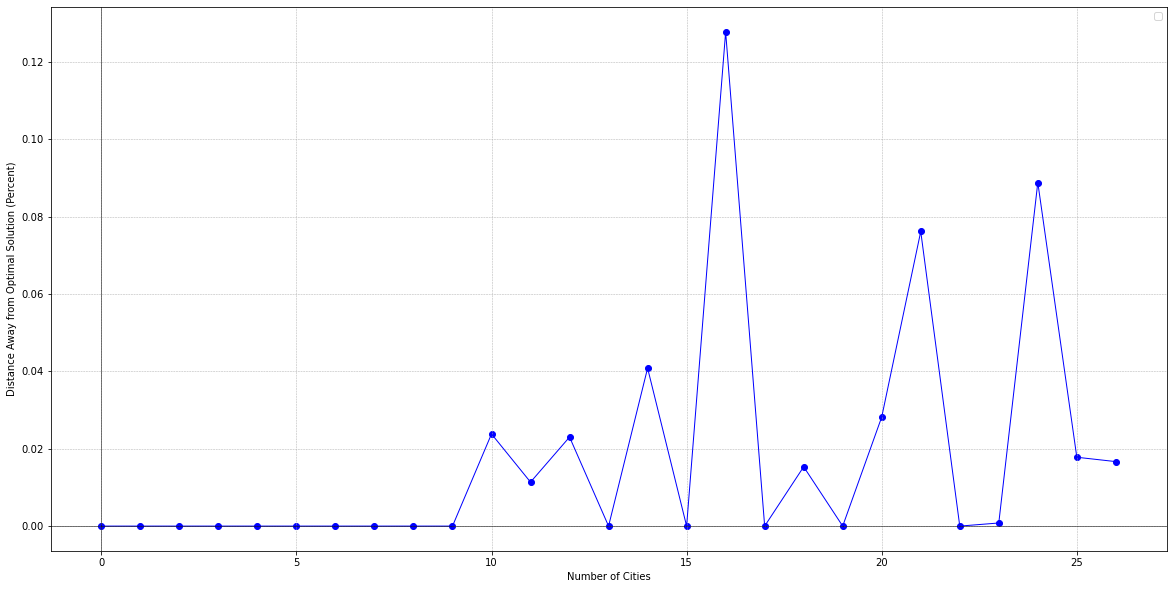

In [44]:
import matplotlib.pyplot as plt

# Assuming 'difference' is a list or array of distances
plt.figure(figsize=(20, 10))

# Plot the scatter points
plt.scatter(range(len(difference)), difference, color='b')

# Plot the line connecting the points
plt.plot(range(len(difference)), difference, color='b', linestyle='-', linewidth=1)

# Customize the axes, title, and grid
plt.xlabel('Number of Cities')
plt.ylabel('Distance Away from Optimal Solution (Percent)')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


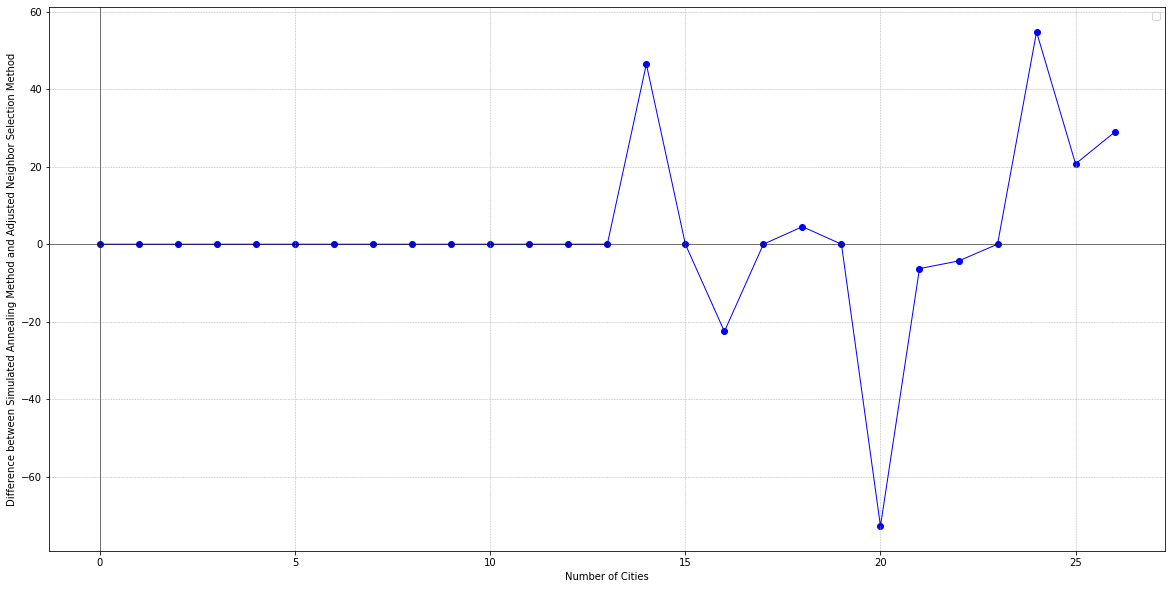

In [23]:
import matplotlib.pyplot as plt

# Assuming 'difference' is a list or array of distances
plt.figure(figsize=(20, 10))

# Plot the distance from the optimal traditional SA solution set
plt.scatter(range(len(difference)), difference, color='b')
plt.plot(range(len(difference)), difference, color='b', linestyle='-', linewidth=1)

# Customize the axes, title, and grid
plt.xlabel('Number of Cities')
plt.ylabel('Difference between Simulated Annealing Method and Adjusted Neighbor Selection Method')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

19507.756497057457
11842.188367222428


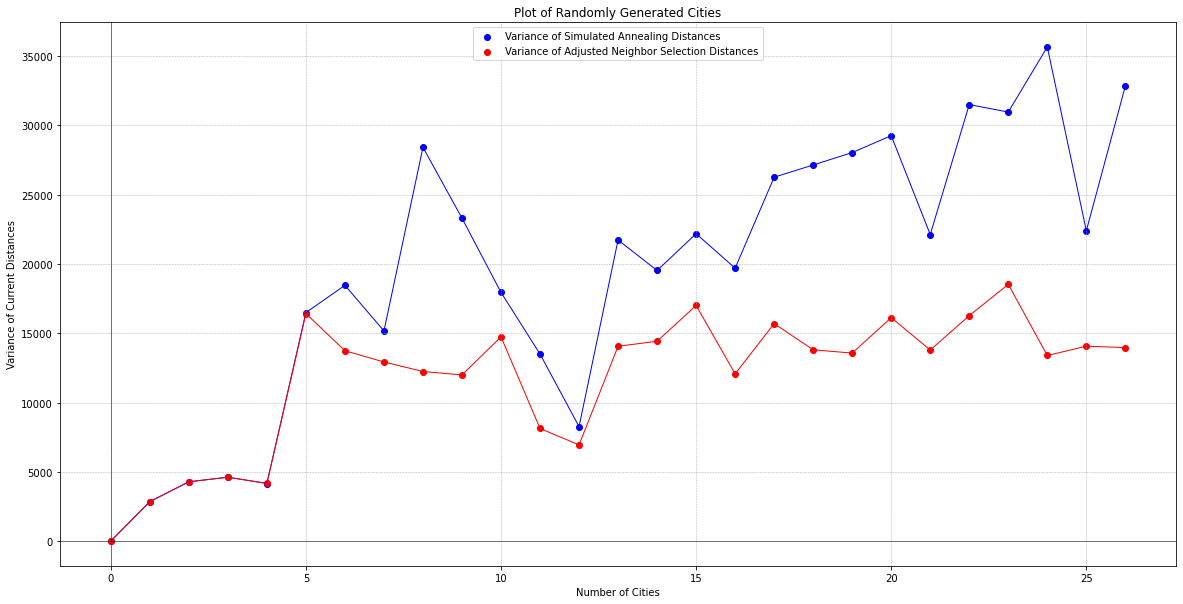

In [20]:
# Assuming 'difference' is a list or array of distances
plt.figure(figsize=(20, 10))

# Plot the scatter points
plt.scatter(range(len(var_distance_SA)), var_distance_SA, color='b', label='Variance of Simulated Annealing Distances')
plt.plot(range(len(var_distance_SA)), var_distance_SA, color='b', linestyle='-', linewidth=1)

plt.scatter(range(len(var_distance_k1)), var_distance_k1, color='r', label='Variance of Adjusted Neighbor Selection Distances')
plt.plot(range(len(var_distance_k1)), var_distance_k1, color='r', linestyle='-', linewidth=1)


print(np.mean(var_distance_SA))
print(np.mean(var_distance_k1))

# Customize the axes, title, and grid
plt.xlabel('Number of Cities')
plt.ylabel('Variance of Current Distances')
plt.title('Plot of Randomly Generated Cities')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()